In [ ]:
%%capture --no-stderr
# % pip install -U langgraph langchain langchain_community, langchain_anthropic

In [18]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

tools = [TavilySearchResults(max_results=1)]

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

tools = [TavilySearchResults(max_results=1)]

llm = ChatAnthropic(model="claude-3-haiku-20240307")
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful customer support assistant for Alaska Airlines."),
    ("placeholder", "{messages}")
])

assistant_runnable = prompt | llm.bind_tools(tools)
def assistant(state: State):
    return {"messages": assistant_runnable.invoke(state)}

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition
builder = StateGraph(State)
builder.add_node("assistant", assistant)
builder.set_entry_point("assistant")
builder.add_node("tools", ToolNode(tools))
builder.add_edge("tools", "assistant")
builder.add_conditional_edges("assistant", tools_condition, {"action": "tools", END: END})
graph = builder.compile()

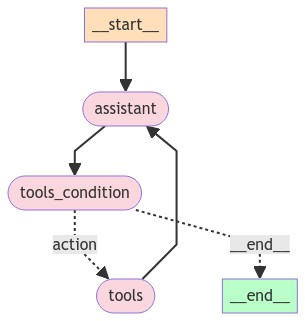

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [26]:
events = graph.stream({"messages": [("user", "Hi there, what's your latest flight today out of San Francisco?")]}, stream_mode="values")
for event in events:
    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            messages = messages[-1]
        print(
            "Assistant:",
            str(messages.content).replace("\n", "\\n")[:50],
        )

Assistant: Hi there, what's your latest flight today out of S
Assistant: [{'id': 'toolu_017CGnZpxUmuoQJoP5VxyFB1', 'input':
Assistant: [{"url": "https://www.alaskaair.com/en/flights-fro
Assistant: Based on the search results, Alaska Airlines has n


In [28]:
event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Based on the search results, Alaska Airlines has numerous flights departing San Francisco each day. However, without more specific details about the desired travel date or destination, I don't have the information to provide details on the latest flight out of San Francisco today. To get that information, I would need to know the specific date you are interested in traveling. Please let me know the date and I'd be happy to look up the latest Alaska Airlines flight departing San Francisco on that day.
